In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import JSON
from dateutil import parser
import isodate

# Environment FIle
from dotenv import load_dotenv
load_dotenv()

# Data visualisation libraries
from googleapiclient.discovery import build

#Data Visual Pakcages
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#Dissable SSL Veriication - Recommend you delete this 
import ssl
import nltk

# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

#Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

# Re-enable SSL verification
ssl._create_default_https_context = ssl.create_default_context

[nltk_data] Downloading package stopwords to /Users/dodo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dodo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Gathering using Youtube API

In [2]:
#Youtube API Key stored in an env file
api_key = os.getenv('api_key')

# Pewdiepie youtube Channel ID = UC-lHJZR3Gqxm24_Vd_AJ5Yw
# Ali-Abdaal youtube Channel ID = UCoOae5nYA7VqaXzerajD0lg
# David Dobrik youtube Channel ID = UCmh5gdwCx6lN7gEC20leNVA
channel_ids = ['UC-lHJZR3Gqxm24_Vd_AJ5Yw',
               #more chanels can be placed here if you want
               ]

#Documentation file from youtube V3 data pack to get a users youtube data as a list

api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [3]:
#Creating a function that will get all the chanels stats and store it into a df
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    """
    
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids) #joins the channel ids if you have more than 1
    )
    response = request.execute()

    #loop through items
    for item in response['items']:
        data = {'ChannelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistID': item['contentDetails']['relatedPlaylists']['uploads']
                
        }
        
        all_data.append(data)

    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    
    #Youtube API limits you to 50 requests per page - work around 
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults = 50,
            pageToken = next_page_token
        )
        response = request.execute()
        
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
            
        next_page_token = response.get('nextPageToken')
        
    return video_ids


def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
    
    all_video_info = []

    for i in range(0, len(video_ids), 50):  ##Takes all the videos that are present in the playlist
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id = ','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']             
                            }

            video_info = {}
            video_info['video_id'] = video['id']
            
            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    #If some stats are missing from the video then we can have an error management = ignore the missing part
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
                        
            
            all_video_info.append(video_info)
        
    return pd.DataFrame(all_video_info)


def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

## Using the functions to get the channel stats

In [4]:
channel_stats = get_channel_stats(youtube, channel_ids)

running the 'channel_stats' function to view what it has pulled

In [5]:
channel_stats

,ChannelName,subscribers,views,totalVideos,playlistID
0,PewDiePie,111000000,29009103156,4712,UU-lHJZR3Gqxm24_Vd_AJ5Yw


Choosing a playlist from the overview

In [6]:
#the channel_id is used as the playlist_id for all the youtubers uploaded videos
#Choose a playlist you would like to analyse
playlist_id = 'UU-lHJZR3Gqxm24_Vd_AJ5Yw'

In [7]:
# Creating a data fram with youtube video stats and the comments from all videos in the playlist
video_ids = get_video_ids(youtube, playlist_id)
video_df = get_video_details(youtube, video_ids)

#The comments usually take the longest time so if you want to save time # this out :D
comments_df = get_comments_in_videos(youtube, video_ids)

Could not get comments for video gf5D0AH8i0k
Could not get comments for video ie3UMwenV9s
Could not get comments for video 6qa3X87SFKE
Could not get comments for video veYSwGigsY0
Could not get comments for video m1sdWS5UQZo
Could not get comments for video J9GpfqyUAVI
Could not get comments for video -Cn2fUrUKRo
Could not get comments for video _AatGduGclc
Could not get comments for video 0-fyoq4454U
Could not get comments for video cL9tZK76BdY
Could not get comments for video gPi8a5zKu_E
Could not get comments for video IIJvmXjyPVo
Could not get comments for video 0J836Uqs_o4
Could not get comments for video p07omlVBxhU
Could not get comments for video nxQO53J2_OQ
Could not get comments for video de_rbQGxahw
Could not get comments for video qujgqReNP_0
Could not get comments for video yHq0GPKmM_A
Could not get comments for video qmEXKOg-pYE
Could not get comments for video 5owENvvZUMU
Could not get comments for video AelzlLDT0pM
Could not get comments for video CAEZ5KzUBGE
Could not 

In [8]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,TOUlWgoILsQ,PewDiePie,"I got hacked, then Banned",#AD - 🌏 Get exclusive NordVPN deal here ➵ http...,"[pewdiepie, pewds, pewdie]",2023-05-25T17:15:02Z,2058208,169129,None,6506,PT16M2S,hd,false
1,WBniggluAe8,PewDiePie,I Tried Making AI Video... Accidentally made N...,#AD - 🌏 Get exclusive NordVPN deal here ➵ http...,"[pewdiepie, pewds, pewdie]",2023-05-14T16:08:26Z,2153722,142333,None,4008,PT15M49S,hd,false
2,IBTM0W1kQ5o,PewDiePie,Think it's time we did a gender reveal,🧎#Subscribe🧎\n\nStock Up On ➡️🥤Gfuel (affiliat...,"[pewdiepie, pewds, pewdie]",2023-05-05T14:59:09Z,3873857,270969,None,13058,PT19M10S,hd,false
3,wycmfVWKWlw,PewDiePie,Only 99.9% Can SOLVE this - Brain It On,#AD - 🌏 Get exclusive NordVPN deal here ➵ http...,"[pewdiepie, pewds, pewdie]",2023-04-29T00:42:11Z,2599590,192651,None,4455,PT14M48S,hd,false
4,ih5SInZ93k4,PewDiePie,Try Not To Laugh Ț̴̈́r̷̹͐y̸̪͝ ̴̳̔Ņ̴͌o̴̹̕t̴̪͌ ...,Get 37% off G FUEL Tubs & Starter Kits! https:...,"[pewdiepie, pewds, pewdie]",2023-04-16T17:30:04Z,2962085,200637,None,4958,PT15M39S,hd,false


In [9]:
comments_df.head()

,video_id,comments
0,TOUlWgoILsQ,[me thinking why does the swedish passport hv ...
1,WBniggluAe8,[“I tried making AI video . . . Accidentally m...
2,IBTM0W1kQ5o,"[OOOOi loved that as a hint, that was fun Feli..."
3,wycmfVWKWlw,"[fr bro, first try as always... right sive? 🗿,..."
4,ih5SInZ93k4,[I don't get the baseball one. Just groped her...


In [ ]:
# Write video data to CSV file for future references
video_df.to_csv('video_data.csv')
comments_df.to_csv('comments_data.csv')

## Data pre-processing & Feature Engineering

In [10]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount          True
likeCount          True
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [11]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [12]:
#Converting some object columns into numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [13]:
#Published day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [14]:
#Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
#there are some nulls so nulls will be replaced by 0 

In [15]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [16]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [17]:
#Changing the duration of a video from a string of numbers and letters to a seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())
##video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]') ### this is not working idk why --- its supposed to convert the 0 days 00:00:00 to 000.0s

In [18]:
#checking the output to see if the duratoin changed to seconds
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,962.0,PT16M2S
1,949.0,PT15M49S
2,1150.0,PT19M10S
3,888.0,PT14M48S
4,939.0,PT15M39S
...,...,...
4539,579.0,PT9M39S
4540,522.0,PT8M42S
4541,193.0,PT3M13S
4542,337.0,PT5M37S


In [19]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,tagCount,likeRatio,commentRatio,titleLength,durationSecs
0,TOUlWgoILsQ,PewDiePie,"I got hacked, then Banned",#AD - 🌏 Get exclusive NordVPN deal here ➵ http...,"[pewdiepie, pewds, pewdie]",2023-05-25 17:15:02+00:00,2058208.0,169129.0,NaN,6506.0,PT16M2S,hd,false,Thursday,3,82.172939,3.161002,25,962.0
1,WBniggluAe8,PewDiePie,I Tried Making AI Video... Accidentally made N...,#AD - 🌏 Get exclusive NordVPN deal here ➵ http...,"[pewdiepie, pewds, pewdie]",2023-05-14 16:08:26+00:00,2153722.0,142333.0,NaN,4008.0,PT15M49S,hd,false,Sunday,3,66.086988,1.860964,57,949.0
2,IBTM0W1kQ5o,PewDiePie,Think it's time we did a gender reveal,🧎#Subscribe🧎\n\nStock Up On ➡️🥤Gfuel (affiliat...,"[pewdiepie, pewds, pewdie]",2023-05-05 14:59:09+00:00,3873857.0,270969.0,NaN,13058.0,PT19M10S,hd,false,Friday,3,69.948116,3.370801,38,1150.0
3,wycmfVWKWlw,PewDiePie,Only 99.9% Can SOLVE this - Brain It On,#AD - 🌏 Get exclusive NordVPN deal here ➵ http...,"[pewdiepie, pewds, pewdie]",2023-04-29 00:42:11+00:00,2599590.0,192651.0,NaN,4455.0,PT14M48S,hd,false,Saturday,3,74.108225,1.713732,39,888.0
4,ih5SInZ93k4,PewDiePie,Try Not To Laugh Ț̴̈́r̷̹͐y̸̪͝ ̴̳̔Ņ̴͌o̴̹̕t̴̪͌ ...,Get 37% off G FUEL Tubs & Starter Kits! https:...,"[pewdiepie, pewds, pewdie]",2023-04-16 17:30:04+00:00,2962085.0,200637.0,NaN,4958.0,PT15M39S,hd,false,Sunday,3,67.735058,1.673821,85,939.0


# Exploratory Data Analysis

### Best Performing Videos:

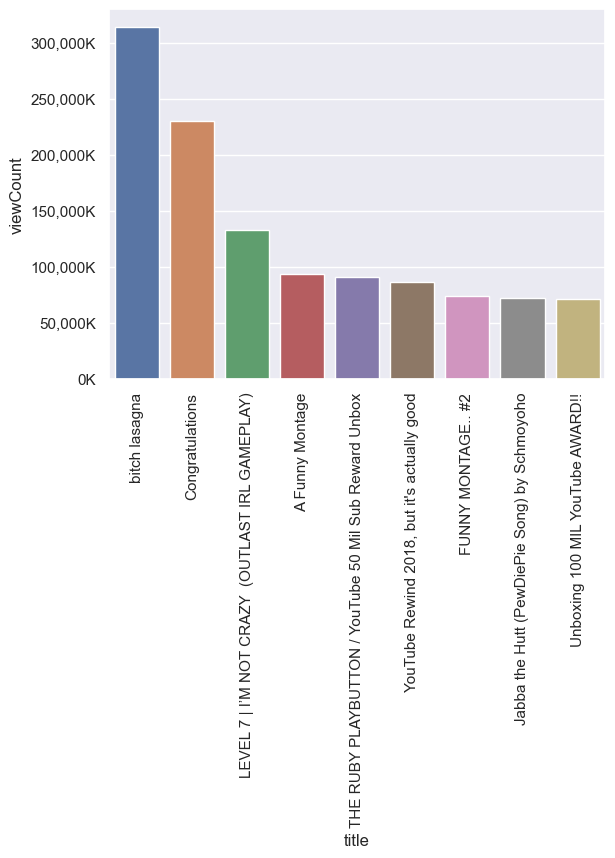

In [20]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False) [0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000)+ 'K'))

### Worst Performing Videos

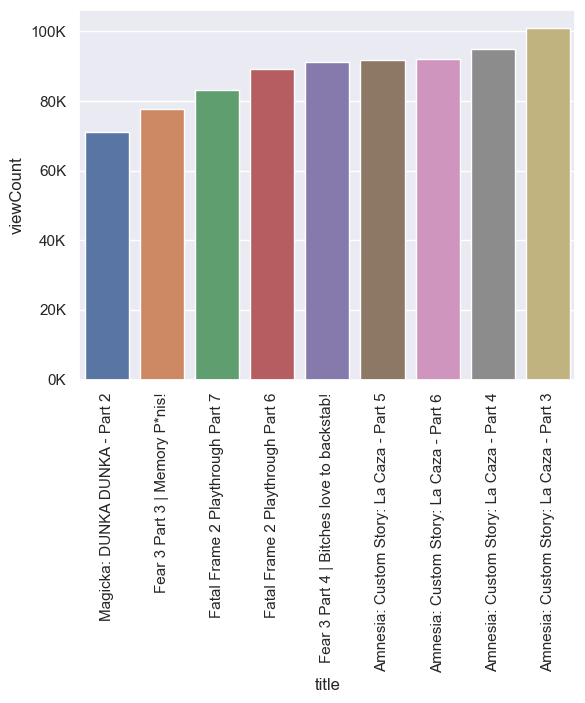

In [21]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True) [0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000)+ 'K'))

## View Distribution Per Video

<Axes: xlabel='channelTitle', ylabel='viewCount'>

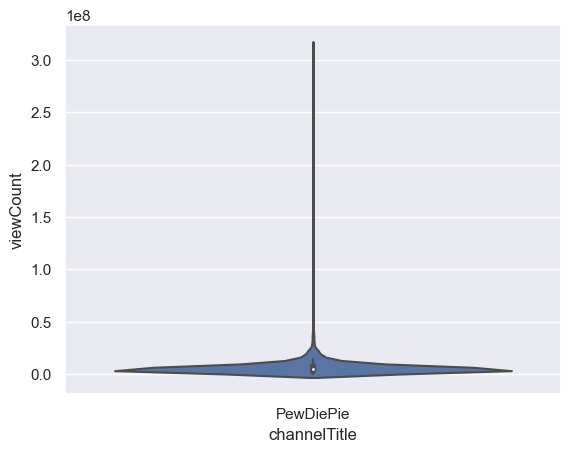

In [22]:
sns.violinplot(x=video_df['channelTitle'], y=video_df['viewCount'])


## Views vs Likes and Comments

<Axes: xlabel='likeCount', ylabel='viewCount'>

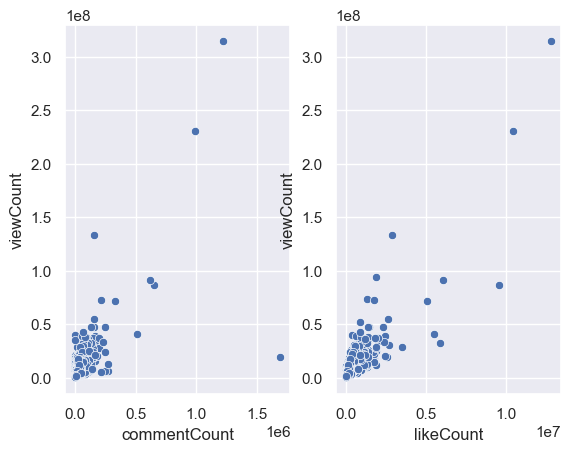

In [23]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Video Duration

<Axes: xlabel='durationSecs', ylabel='Count'>

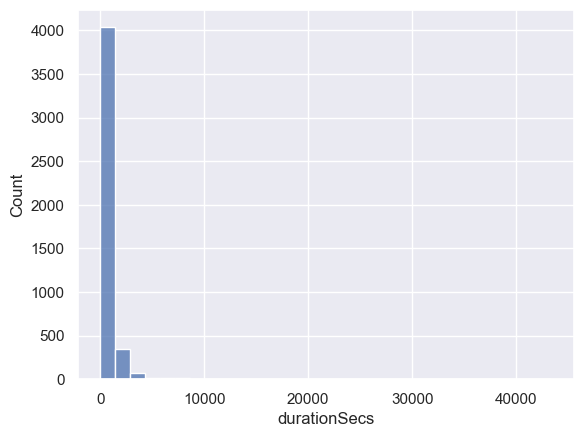

In [24]:
sns.histplot(data = video_df, x = 'durationSecs', bins = 30)

### Title length vs views
#### Checking to see if the title length as an indication for views


<Axes: xlabel='titleLength', ylabel='viewCount'>

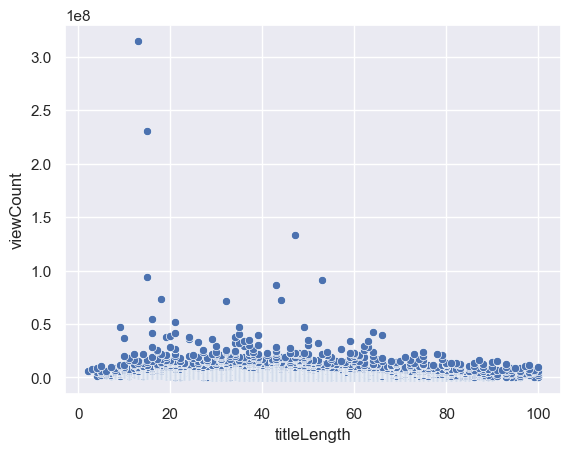

In [25]:

sns.scatterplot(x = 'titleLength', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True))
# Increase spacing between y-axis ticks
# Set y-axis tick locator to multiples of 100
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(base=100))
# Invert the y-axis direction
#plt.gca().invert_yaxis()

## Wordcloud for video Titles

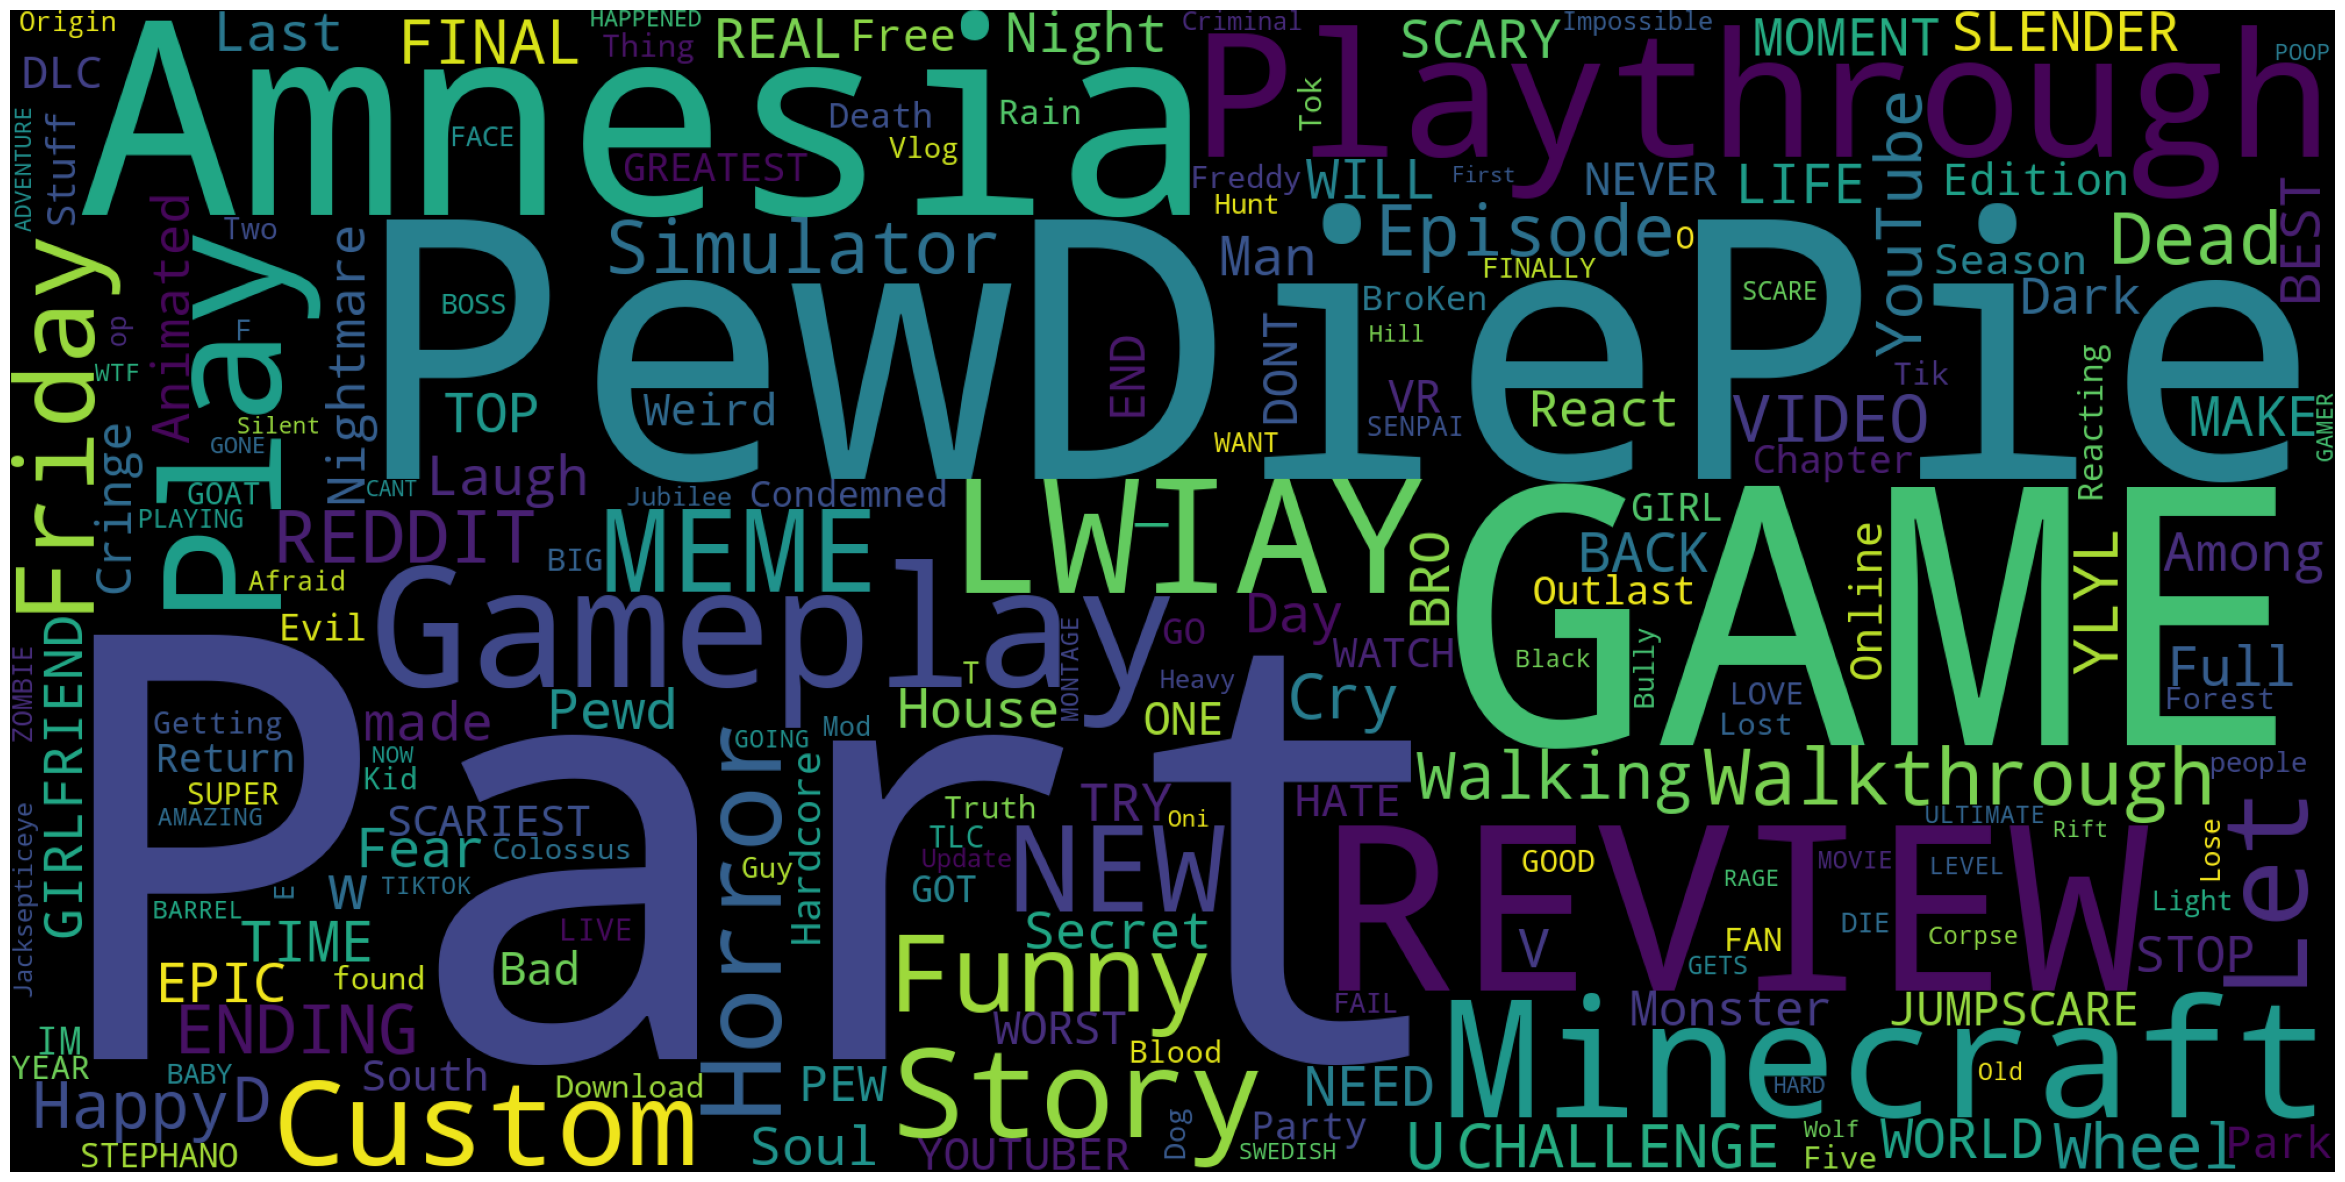

In [26]:

stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)


## Upload Schedule

Text(0, 0.5, 'Count')

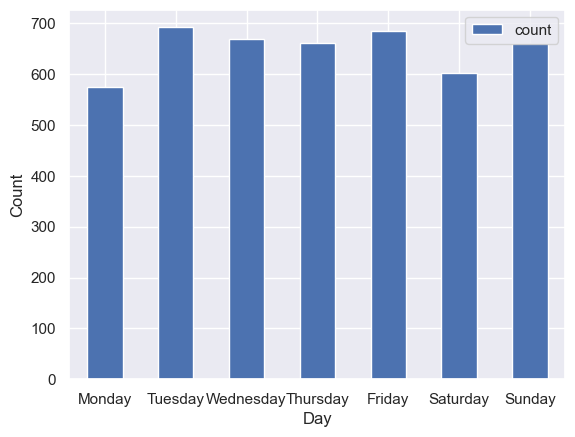

In [27]:
day_df = pd.DataFrame(video_df['publishedDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.plot.bar(rot=0)
ax.set_xlabel('Day')
ax.set_ylabel('Count')



## WordCloud for Video Comments

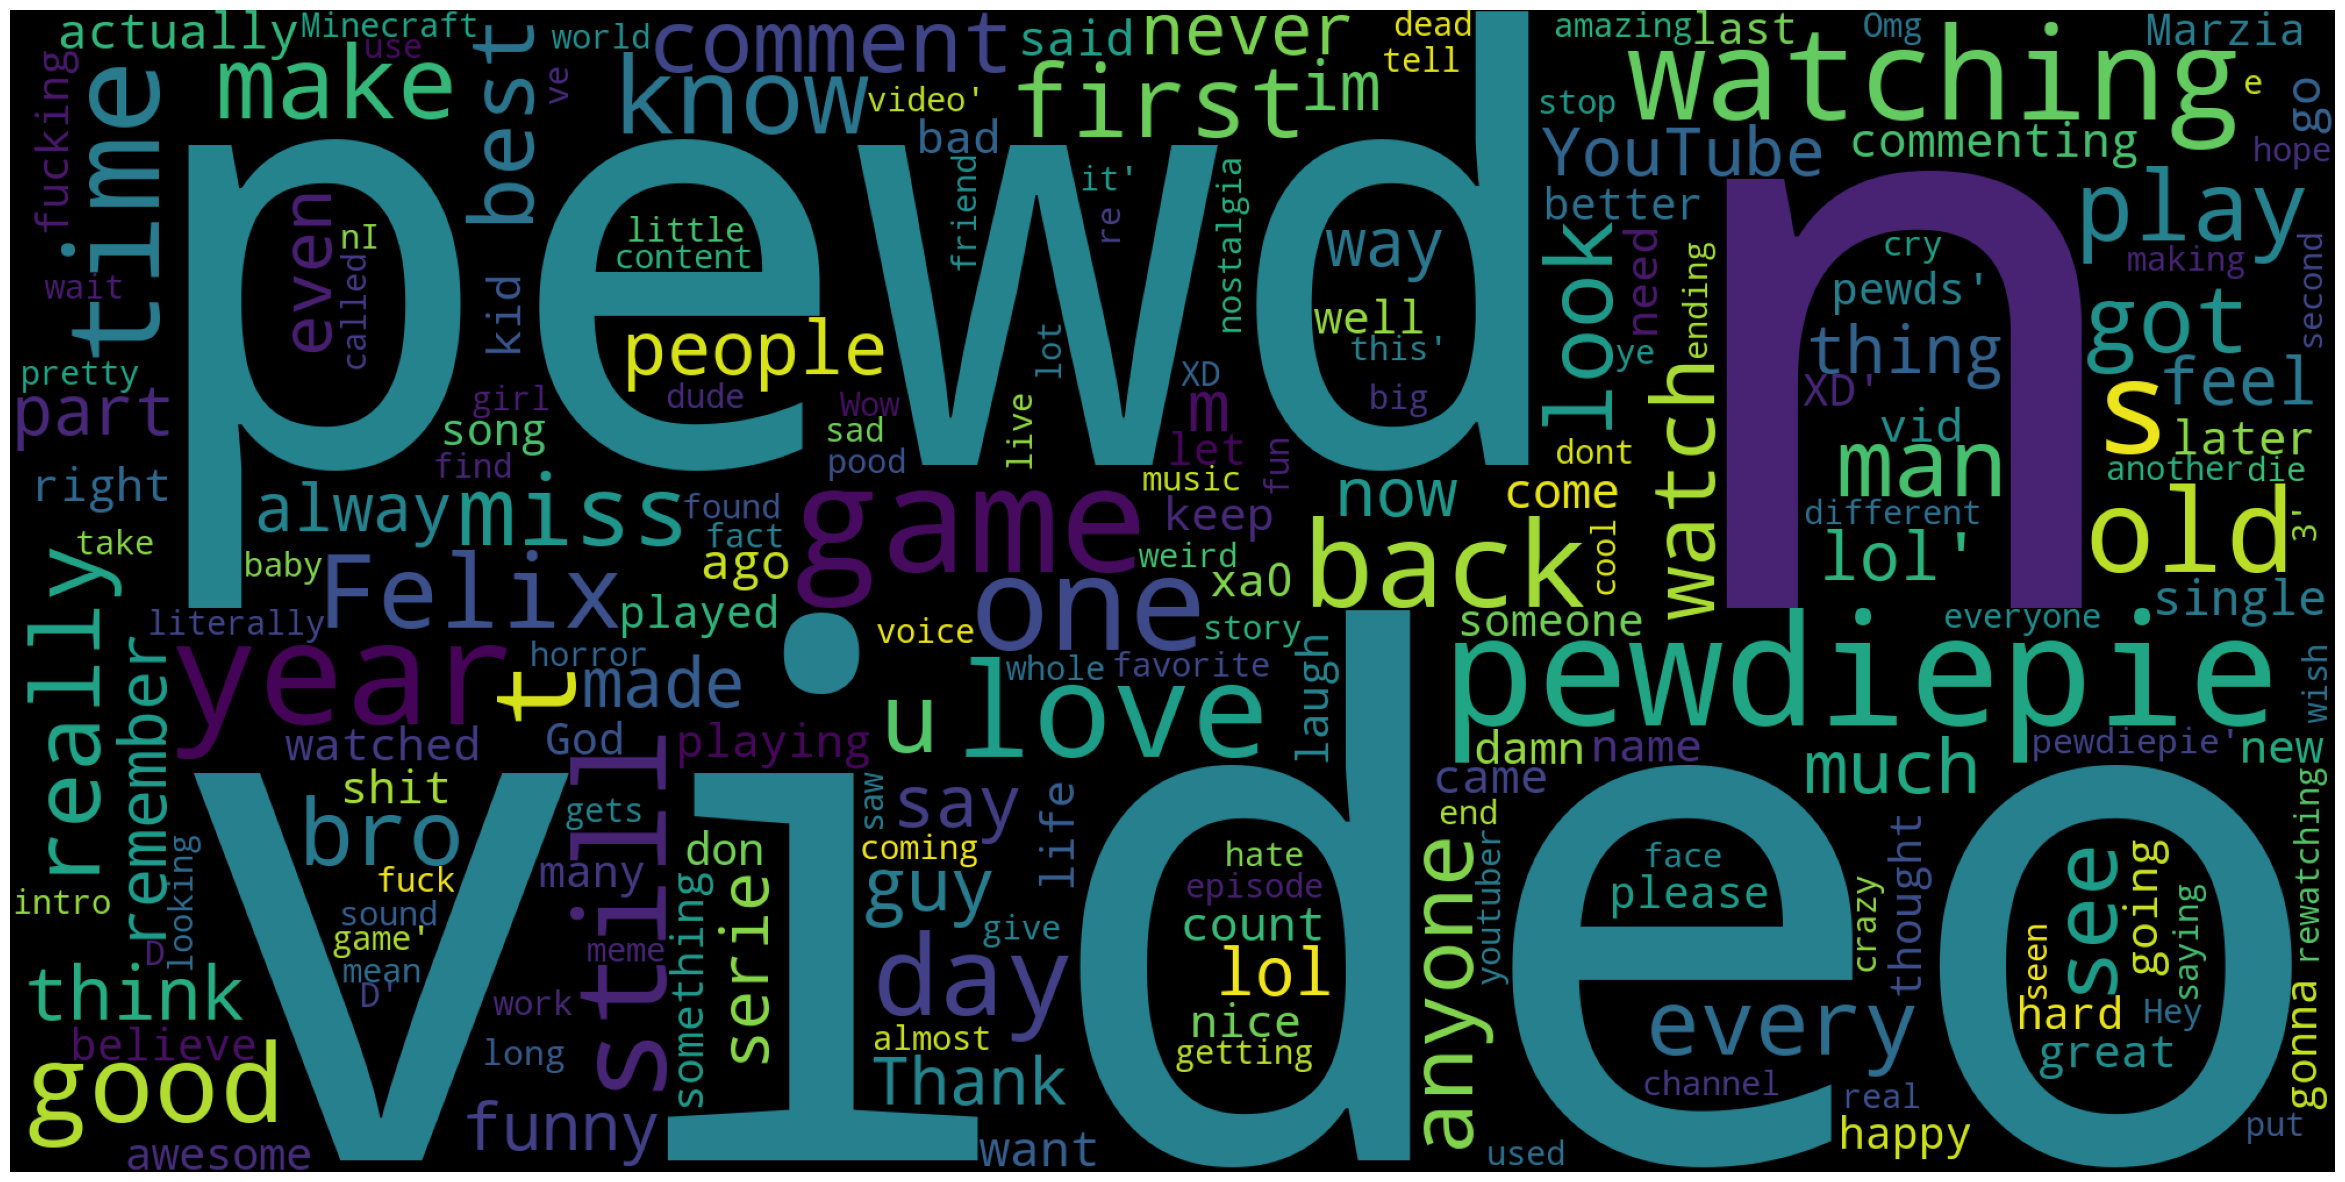

In [28]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)